# TensorFlow Models

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

os.chdir(r'C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels\HelperFunctions')
import auxiliaries as aux
os.chdir(r'C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels')

## Autoregressive Model

- Good start
- Very inaccurate

In [2]:
# Develop Testing and Applied Window
species = 'Deer'
file_name = 'GSM02927_interpolated'

test_window = aux.WindowGenerator(input_width=aux.OUT_STEPS,
                               label_width=aux.OUT_STEPS,
                               shift=aux.OUT_STEPS,
                               cv_name=f'{species}\\{file_name}')

results = {}

print(f'{species}:')
print(f'Original Data Size: {len(test_window.orig_df)}')
print(f'Training Data Size: {len(test_window.train_df)}')
print(f'Validation Data Size: {len(test_window.val_df)}')
print(f'Testing Data Size: {len(test_window.test_df)}')

Deer:
Original Data Size: 2940
Training Data Size: 2352
Validation Data Size: 294
Testing Data Size: 294


In [3]:
autoregressive_model = aux.FeedBack(units=32, out_steps=aux.OUT_STEPS, num_vars=3)

In [4]:
history = aux.compile_and_fit(autoregressive_model, test_window)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - loss: 1.3873 - mean_absolute_error: 1.0274 - val_loss: 1.8353 - val_mean_absolute_error: 1.1243
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.5490 - mean_absolute_error: 1.0831 - val_loss: 1.4131 - val_mean_absolute_error: 1.0242
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.3293 - mean_absolute_error: 0.9630 - val_loss: 1.5761 - val_mean_absolute_error: 0.9944
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.0075 - mean_absolute_error: 0.7866 - val_loss: 1.6226 - val_mean_absolute_error: 0.9707


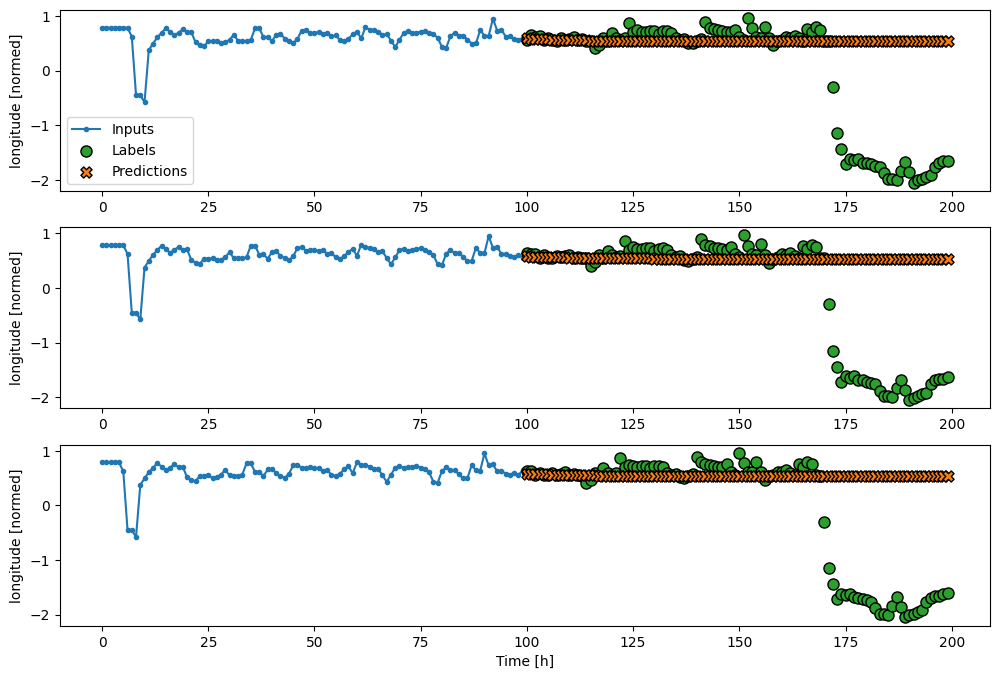

In [5]:
test_window.plot(autoregressive_model, plot_col='longitude')

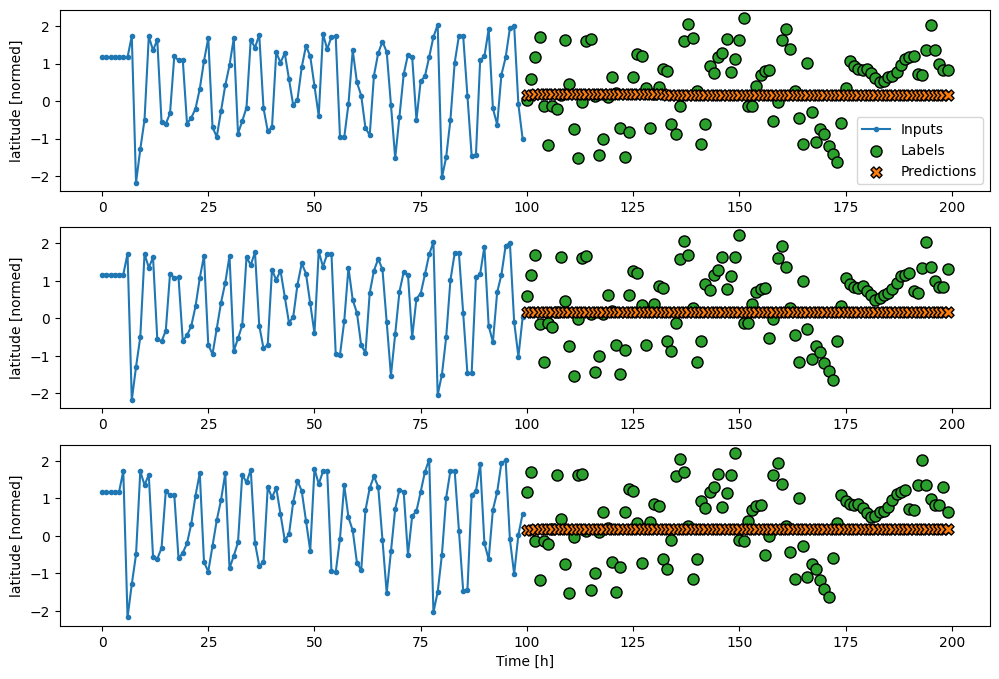

In [6]:
test_window.plot(autoregressive_model, plot_col='latitude')

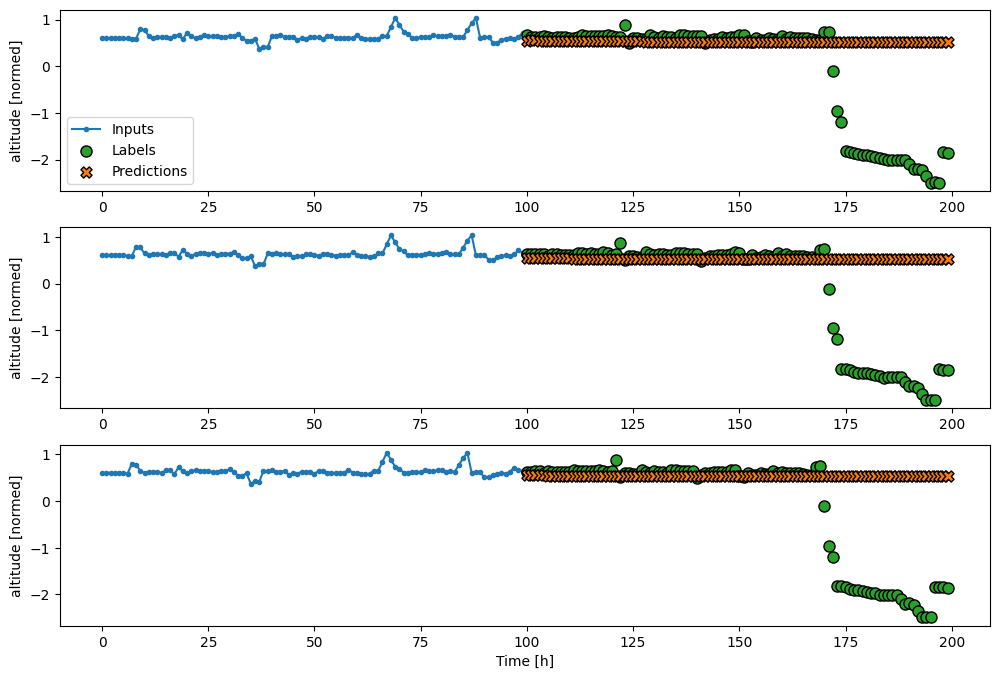

In [7]:
test_window.plot(autoregressive_model, plot_col='altitude')

In [8]:
results['Autoregressive'] = autoregressive_model.evaluate(test_window.test, verbose=1, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6301 - mean_absolute_error: 0.7211


In [9]:
test_window.extend_to_csv(url_dest=f'{species}/{file_name}_autoregressive', species=species, model=autoregressive_model)
autoregressive_model.save(f'ModelCreation/SavedModels/{file_name}_autoregressive.keras')

## Single Shot Model

In [10]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(aux.OUT_STEPS*len(test_window.column_indices),
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([aux.OUT_STEPS, len(test_window.column_indices)])
    ])

history = aux.compile_and_fit(multi_conv_model, test_window)

Epoch 1/20

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.3214 - mean_absolute_error: 1.0123 - val_loss: 1.3303 - val_mean_absolute_error: 0.8930
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8853 - mean_absolute_error: 0.7177 - val_loss: 1.5835 - val_mean_absolute_error: 0.9630
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9280 - mean_absolute_error: 0.7275 - val_loss: 1.5729 - val_mean_absolute_error: 0.9441


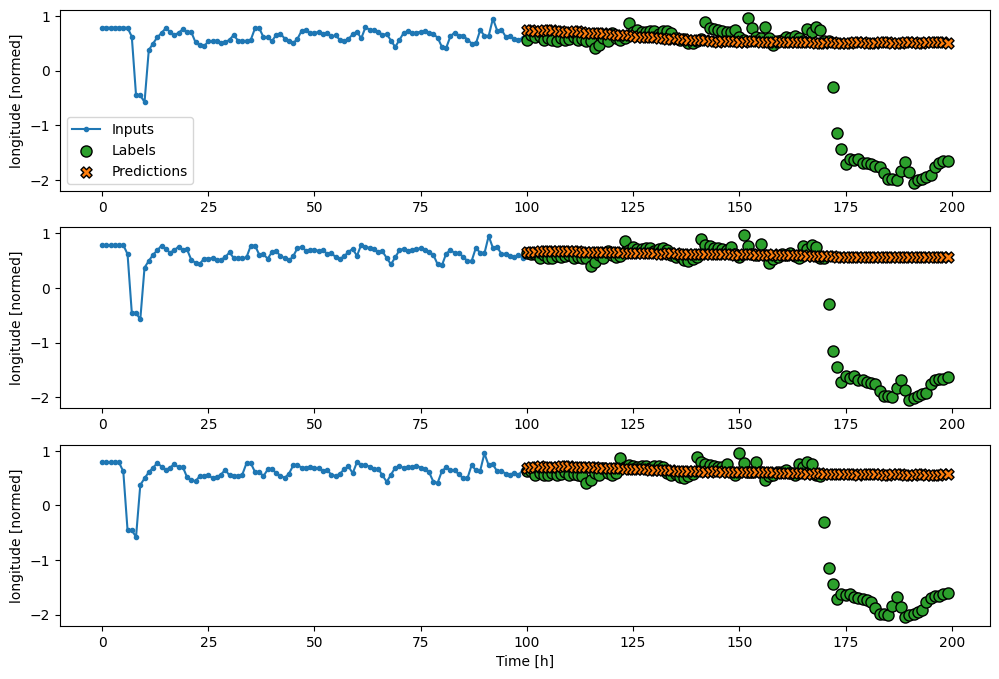

In [11]:
test_window.plot(multi_conv_model, plot_col='longitude')

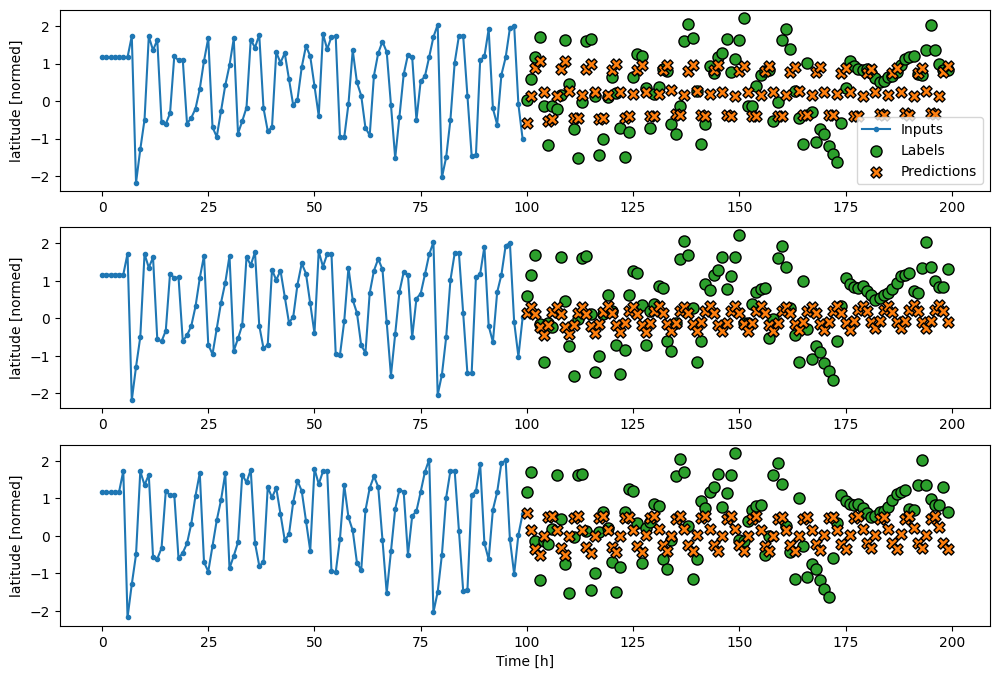

In [12]:
test_window.plot(multi_conv_model, plot_col='latitude')

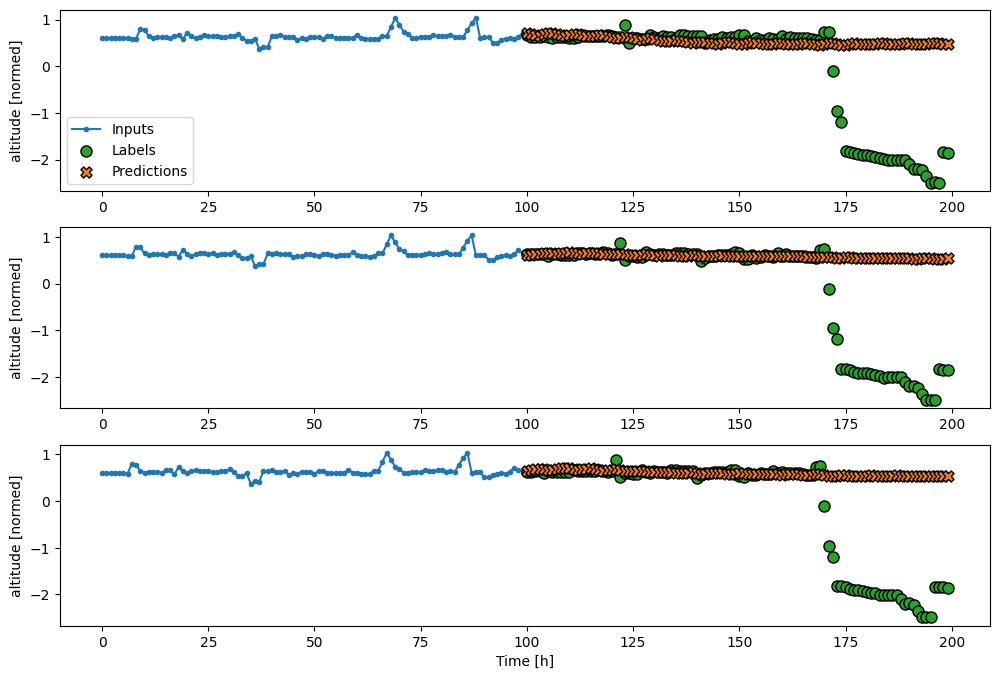

In [13]:
test_window.plot(multi_conv_model, plot_col='altitude')

In [14]:
results['Single Shot'] = multi_conv_model.evaluate(test_window.test, verbose=1, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5438 - mean_absolute_error: 0.6591 


In [15]:
test_window.extend_to_csv(url_dest=f'{species}\\{file_name}_singleshot', species=species, model=multi_conv_model)
multi_conv_model.save(f'ModelCreation\\SavedModels\\{file_name}_singleshot.keras')

## My Model

## Final Results

In [16]:
results_df = pd.DataFrame(results).T.rename({'loss': 'Loss', 'mean_absolute_error': 'Mean_Absolute_Error'}, axis=1)

results_df.to_csv(f'ModelCreation\\{file_name}_test_data.csv', index_label='Model_Name')